In [6]:
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Load the dataset from the uploaded file
try:
    df = pd.read_csv('survey_datav3.csv')
    print(" Dataset loaded successfully!")
except FileNotFoundError:
    print("Error: 'survey_datav3.csv' not found.")

 Dataset loaded successfully!


In [17]:
# --- Data Cleaning ---
# Clean column names more robustly to handle extra spaces
# 1. Strip leading/trailing whitespace from column names
df.columns = df.columns.str.strip()
# 2. Replace multiple spaces within column names with a single space
df.columns = df.columns.str.replace(r'\s+', ' ', regex=True)

print("✅ Column names cleaned successfully.")

# --- Feature Engineering ---
# Define the function to assign event labels based on survey responses
def assign_event_label(row):
    # Rule 1: Coding Competition / Hackathon
    if (row['Tech Meetups & Hackathons interest ratings'] >= 4 and
        row['What type of academic content are you most interested in?'] == 'Practical & Technical Skills' and
        row['Which faculty are you currently enrolled in?'] in ['Faculty of Technology', 'Faculty of Applied Sciences']):
        return 'Coding Competition / Hackathon'
    # Rule 2: Business Pitch Competition
    if (row['Business Idea competition? interest ratings'] >= 4 and
        row['What type of academic content are you most interested in?'] in ['Business & Management', 'Communication & Leadership']):
        return 'Business Pitch Competition'
    # Rule 3: Research Symposium
    if (row['What type of academic content are you most interested in?'] == 'Research & Academic Writing' and
        row['Academic Workshops interest ratings'] >= 4):
        return 'Research Symposium'
    # Rule 4: Leadership Workshop
    if (row['What type of academic content are you most interested in?'] == 'Communication & Leadership' and
        row['Academic Workshops interest ratings'] >= 4):
        return 'Leadership Workshop'
    # Rule 5: Health and Wellness Seminar
    if row['A workshop on Mental Health & Stress Management? interest ratings'] >= 5:
        return 'Health and Wellness Seminar'
    # Rule 6: Creative Thinking Workshop
    if (row['What type of academic content are you most interested in?'] == 'Creative & Critical Thinking' and
        row['Academic Workshops interest ratings'] >= 4):
        return 'Creative Thinking Workshop'
    # Rule 7: Data Science Bootcamp
    if (row['What type of academic content are you most interested in?'] == 'Data Analysis & Statistics' and
        row['Tech Meetups & Hackathons interest ratings'] >= 4):
        return 'Data Science Bootcamp'
    # Rule 8: Peer Study Group Session (Fallback)
    if row['Study Groups and Peer Discussions interest ratings'] >= 4:
        return 'Peer Study Group Session'
    # Default label
    return 'General Academic Workshop'

# Apply the function to create the new 'event_label' column
df['event_label'] = df.apply(assign_event_label, axis=1)

print("\n✅ 'event_label' column created successfully.")
print("\nDistribution of event labels:")
print(df['event_label'].value_counts())

✅ Column names cleaned successfully.

✅ 'event_label' column created successfully.

Distribution of event labels:
event_label
General Academic Workshop         138
Peer Study Group Session           53
Health and Wellness Seminar        38
Business Pitch Competition         26
Research Symposium                 24
Leadership Workshop                16
Coding Competition / Hackathon     14
Data Science Bootcamp               9
Creative Thinking Workshop          4
Name: count, dtype: int64


In [18]:
from tensorflow.keras.utils import to_categorical

# 1. Separate the features (X) from the target (y)
X = df.drop('event_label', axis=1)
y = df['event_label']

# 2. Encode the target labels into integers first
label_encoder = LabelEncoder()
y_integers = label_encoder.fit_transform(y)

# 3. *** NEW: Convert integer labels to one-hot encoded vectors ***
y_categorical = to_categorical(y_integers)

# 4. Split the data into training (80%) and testing (20%) sets
#    Note that we are now using y_categorical
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y_categorical, # Use the new one-hot encoded labels
    test_size=0.2,
    random_state=42,
    stratify=y_categorical
)

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")
print("\nShape of one-hot encoded y_train:", y_train.shape)
print("Example of a one-hot encoded label for the first training sample:")
print(y_train[0])

Training set shape: (257, 8)
Testing set shape: (65, 8)

Shape of one-hot encoded y_train: (257, 9)
Example of a one-hot encoded label for the first training sample:
[0. 0. 0. 0. 1. 0. 0. 0. 0.]


In [19]:
# Identify categorical features to be one-hot encoded
categorical_features = X.select_dtypes(include=['object', 'category']).columns

# Create the preprocessing pipeline for the input features (X)
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'
)

# Create the full data processing pipeline
processing_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('scaler', StandardScaler(with_mean=False))
])

print("✅ Preprocessing pipeline created.")

✅ Preprocessing pipeline created.


In [20]:
# Fit the pipeline on the training data and transform it
X_train_processed = processing_pipeline.fit_transform(X_train)

# Transform the testing data using the already-fitted pipeline
X_test_processed = processing_pipeline.transform(X_test)

print(f"Shape of processed training data: {X_train_processed.shape}")
print(f"Shape of processed testing data: {X_test_processed.shape}")

Shape of processed training data: (257, 19)
Shape of processed testing data: (65, 19)


In [27]:
# Get the number of input features and output classes dynamically
n_features = X_train_processed.shape[1]
n_classes = len(label_encoder.classes_)

# Define the model architecture
model = Sequential([
    Dense(256, activation='relu', input_shape=(n_features,)), # Increased from 128
    Dropout(0.3),
    Dense(128, activation='relu'), # Increased from 64
    Dense(64, activation='relu'), # Increased from 32
    Dense(n_classes, activation='softmax')
])

# Print a summary of the model
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_11 (Dense)            (None, 256)               5120      
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_12 (Dense)            (None, 128)               32896     
                                                                 
 dense_13 (Dense)            (None, 64)                8256      
                                                                 
 dense_14 (Dense)            (None, 9)                 585       
                                                                 
Total params: 46,857
Trainable params: 46,857
Non-trainable params: 0
_________________________________________________________________


In [28]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy', # <-- UPDATED LOSS FUNCTION
    metrics=['accuracy']
)

print("✅ Model compiled successfully with 'categorical_crossentropy'.")

✅ Model compiled successfully with 'categorical_crossentropy'.


In [29]:
print("🚀 Starting model training...")

history = model.fit(
    X_train_processed,
    y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)

print("✅ Model training complete.")

🚀 Starting model training...
Epoch 1/50
8/8 [==============================] - 1s 42ms/step - loss: 1.9337 - accuracy: 0.3810 - val_loss: 1.6353 - val_accuracy: 0.4615
Epoch 2/50
8/8 [==============================] - 0s 12ms/step - loss: 1.7495 - accuracy: 0.4286 - val_loss: 1.4885 - val_accuracy: 0.4615
Epoch 3/50
8/8 [==============================] - 0s 14ms/step - loss: 1.6120 - accuracy: 0.4589 - val_loss: 1.4550 - val_accuracy: 0.5385
Epoch 4/50
8/8 [==============================] - 0s 21ms/step - loss: 1.4653 - accuracy: 0.4892 - val_loss: 1.3138 - val_accuracy: 0.5385
Epoch 5/50
8/8 [==============================] - 0s 16ms/step - loss: 1.3292 - accuracy: 0.5541 - val_loss: 1.2154 - val_accuracy: 0.6154
Epoch 6/50
8/8 [==============================] - 0s 13ms/step - loss: 1.1596 - accuracy: 0.6061 - val_loss: 1.0684 - val_accuracy: 0.6538
Epoch 7/50
8/8 [==============================] - 0s 14ms/step - loss: 1.0703 - accuracy: 0.6104 - val_loss: 1.1434 - val_accuracy: 0.538

In [30]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test_processed, y_test, verbose=0)
print(f"\n📈 Test Accuracy: {accuracy*100:.2f}%")

# Generate predicted probabilities
y_pred_probs = model.predict(X_test_processed)

# --- UPDATED: Convert predictions and one-hot y_test back to integers ---
y_pred_integers = np.argmax(y_pred_probs, axis=1)
y_test_integers = np.argmax(y_test, axis=1)

# Print the classification report using the integer labels
print("\n📋 Classification Report:")
print(classification_report(y_test_integers, y_pred_integers, target_names=label_encoder.classes_))


📈 Test Accuracy: 80.00%
3/3 [==============================] - 0s 6ms/step

📋 Classification Report:
                                precision    recall  f1-score   support

    Business Pitch Competition       0.60      0.60      0.60         5
Coding Competition / Hackathon       0.60      1.00      0.75         3
    Creative Thinking Workshop       1.00      1.00      1.00         1
         Data Science Bootcamp       1.00      1.00      1.00         2
     General Academic Workshop       0.85      0.82      0.84        28
   Health and Wellness Seminar       0.67      0.86      0.75         7
           Leadership Workshop       0.50      0.33      0.40         3
      Peer Study Group Session       0.89      0.73      0.80        11
            Research Symposium       1.00      1.00      1.00         5

                      accuracy                           0.80        65
                     macro avg       0.79      0.82      0.79        65
                  weighted avg  

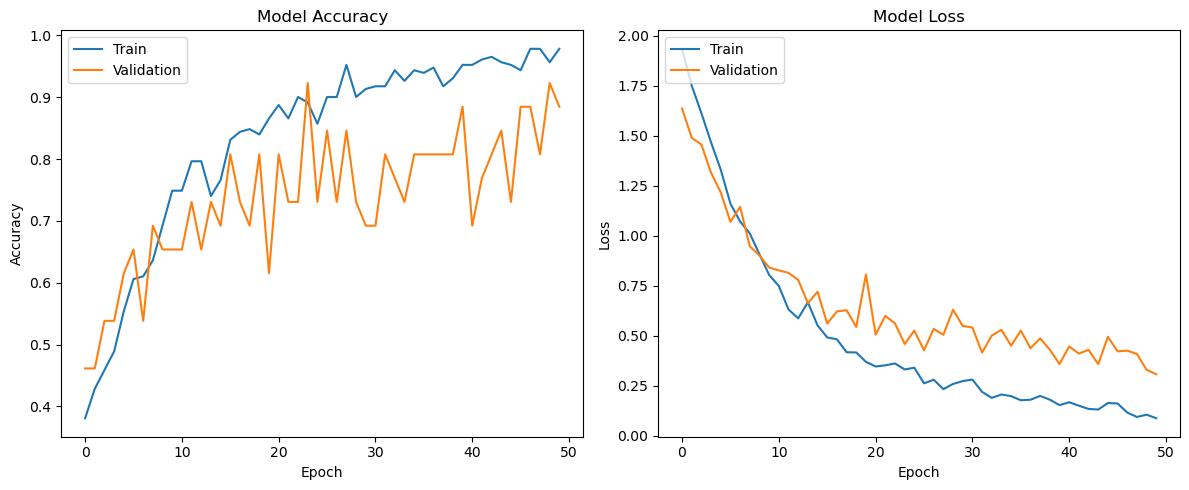

In [32]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [37]:
import joblib

# --- Save the Trained Model ---
# The standard Keras format is .keras
model.save('event_recommender_model.h5')
print(" Keras model saved to 'event_recommender_model.h5'")

# --- Save the Scikit-Learn Objects ---
# We need to save the pipeline and the label encoder
joblib.dump(processing_pipeline, 'processing_pipeline.joblib')
print(" Processing pipeline saved to 'processing_pipeline.joblib'")

joblib.dump(label_encoder, 'label_encoder.joblib')
print(" Label encoder saved to 'label_encoder.joblib'")

 Keras model saved to 'event_recommender_model.h5'
 Processing pipeline saved to 'processing_pipeline.joblib'
 Label encoder saved to 'label_encoder.joblib'


In [39]:
import pandas as pd
import numpy as np
import tensorflow as tf
import joblib
import warnings

# Suppress some warnings for a cleaner output
warnings.filterwarnings('ignore', category=UserWarning, module='sklearn')

# --- Step 1: Load the Saved Model and Processors ---
try:
    # Use the .h5 model file
    model = tf.keras.models.load_model('event_recommender_model.h5')
    pipeline = joblib.load('processing_pipeline.joblib')
    label_encoder = joblib.load('label_encoder.joblib')
    print("✅ Model and processors loaded successfully!")
except (FileNotFoundError, IOError) as e:
    print(f"❌ Error: Could not load necessary files. Make sure 'event_recommender_model.h5', 'processing_pipeline.joblib', and 'label_encoder.joblib' are in the same directory.")
    model = None

# --- Step 2: Create a function to get student data via questions ---
def get_student_profile():
    """
    Asks the user a series of questions to build a student profile dictionary.
    """
    print("\n--- Please Enter New Student Details ---")
    
    faculties = ['Faculty of Technology', 'Faculty of Applied Sciences', 'Faculty of Social Sciences and Humanities', 'Faculty of Medicine and Allied Sciences', 'Faculty of Agriculture']
    yes_no = ['Yes', 'No']
    content_types = ['Practical & Technical Skills', 'Communication & Leadership', 'Data Analysis & Statistics', 'Research & Academic Writing', 'Creative & Critical Thinking', 'Business & Management']

    profile = {}

    # Faculty Question
    print("\n1. Which faculty are you currently enrolled in?")
    for i, faculty in enumerate(faculties):
        print(f"  [{i+1}] {faculty}")
    while True:
        try:
            choice = int(input("   Enter the number for your choice: "))
            if 1 <= choice <= len(faculties):
                profile['Which faculty are you currently enrolled in?'] = faculties[choice - 1]
                break
            else:
                print("   Invalid number. Please try again.")
        except ValueError:
            print("   Please enter a valid number.")

    # Interest Ratings Questions
    def get_rating(question):
        while True:
            try:
                rating = int(input(f"{question} (Enter a number from 1 to 5): "))
                if 1 <= rating <= 5:
                    return rating
                else:
                    print("   Invalid rating. Please enter a number between 1 and 5.")
            except ValueError:
                print("   Please enter a valid number.")
    
    # --- *** THE FIX IS HERE: Dictionary keys now have single spaces to match the cleaned data *** ---
    profile['Study Groups and Peer Discussions interest ratings'] = get_rating("\n2. Rate your interest in Study Groups")
    profile['Academic Workshops interest ratings'] = get_rating("3. Rate your interest in Academic Workshops")
    profile['Tech Meetups & Hackathons interest ratings'] = get_rating("4. Rate your interest in Tech Meetups & Hackathons")
    profile['Business Idea competition? interest ratings'] = get_rating("5. Rate your interest in Business Idea Competitions")
    profile['A workshop on Mental Health & Stress Management? interest ratings'] = get_rating("6. Rate your interest in Mental Health Workshops")

    # Club Member Question
    print("\n7. Are you currently a member of any university club or society?")
    for i, ans in enumerate(yes_no):
        print(f"  [{i+1}] {ans}")
    while True:
        try:
            choice = int(input("   Enter the number for your choice: "))
            if 1 <= choice <= len(yes_no):
                profile['Are you currently a member of any university club or society?'] = yes_no[choice - 1]
                break
            else:
                print("   Invalid number. Please try again.")
        except ValueError:
            print("   Please enter a valid number.")

    # Academic Content Question
    print("\n8. What type of academic content are you most interested in?")
    for i, content in enumerate(content_types):
        print(f"  [{i+1}] {content}")
    while True:
        try:
            choice = int(input("   Enter the number for your choice: "))
            if 1 <= choice <= len(content_types):
                profile['What type of academic content are you most interested in?'] = content[choice - 1]
                break
            else:
                print("   Invalid number. Please try again.")
        except ValueError:
            print("   Please enter a valid number.")
            
    return profile

# --- Step 3: Run the Prediction Pipeline ---
if model:
    new_student_data = get_student_profile()
    new_student_df = pd.DataFrame([new_student_data])
    new_student_processed = pipeline.transform(new_student_df)
    prediction_probabilities = model.predict(new_student_processed)
    predicted_class_index = np.argmax(prediction_probabilities, axis=1)[0]
    predicted_event = label_encoder.inverse_transform([predicted_class_index])[0]

    print("\n" + "="*40)
    print("🎉      EVENT RECOMMENDATION      🎉")
    print("="*40)
    print(f"\nBased on your profile, we suggest you attend a:")
    print(f"\n   >>   **{predicted_event}** <<")
    print("\n" + "="*40)

✅ Model and processors loaded successfully!

--- Please Enter New Student Details ---

1. Which faculty are you currently enrolled in?
  [1] Faculty of Technology
  [2] Faculty of Applied Sciences
  [3] Faculty of Social Sciences and Humanities
  [4] Faculty of Medicine and Allied Sciences
  [5] Faculty of Agriculture


   Enter the number for your choice:  2

2. Rate your interest in Study Groups (Enter a number from 1 to 5):  2
3. Rate your interest in Academic Workshops (Enter a number from 1 to 5):  1
4. Rate your interest in Tech Meetups & Hackathons (Enter a number from 1 to 5):  4
5. Rate your interest in Business Idea Competitions (Enter a number from 1 to 5):  1
6. Rate your interest in Mental Health Workshops (Enter a number from 1 to 5):  2



7. Are you currently a member of any university club or society?
  [1] Yes
  [2] No


   Enter the number for your choice:  1



8. What type of academic content are you most interested in?
  [1] Practical & Technical Skills
  [2] Communication & Leadership
  [3] Data Analysis & Statistics
  [4] Research & Academic Writing
  [5] Creative & Critical Thinking
  [6] Business & Management


   Enter the number for your choice:  3


1/1 [==============================] - 0s 100ms/step

🎉      EVENT RECOMMENDATION      🎉

Based on your profile, we suggest you attend a:

   >>   **General Academic Workshop** <<

